# Basic CHROM Method

(5, 361, 3)
(5, 311, 3)


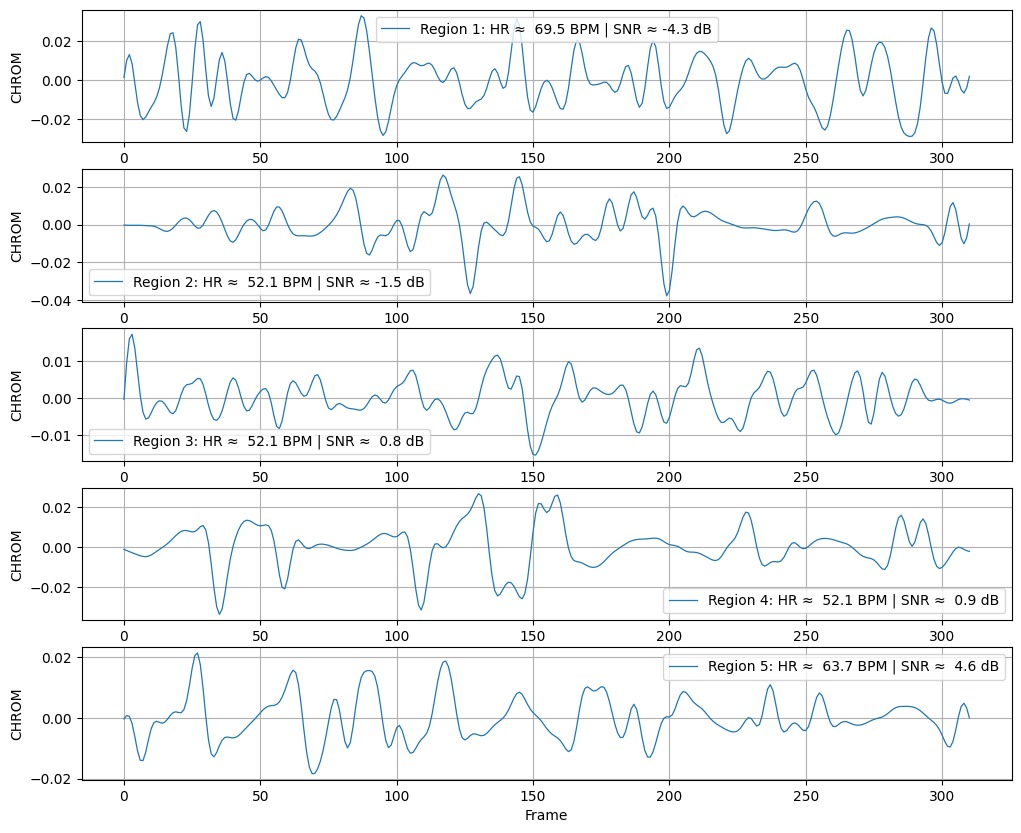

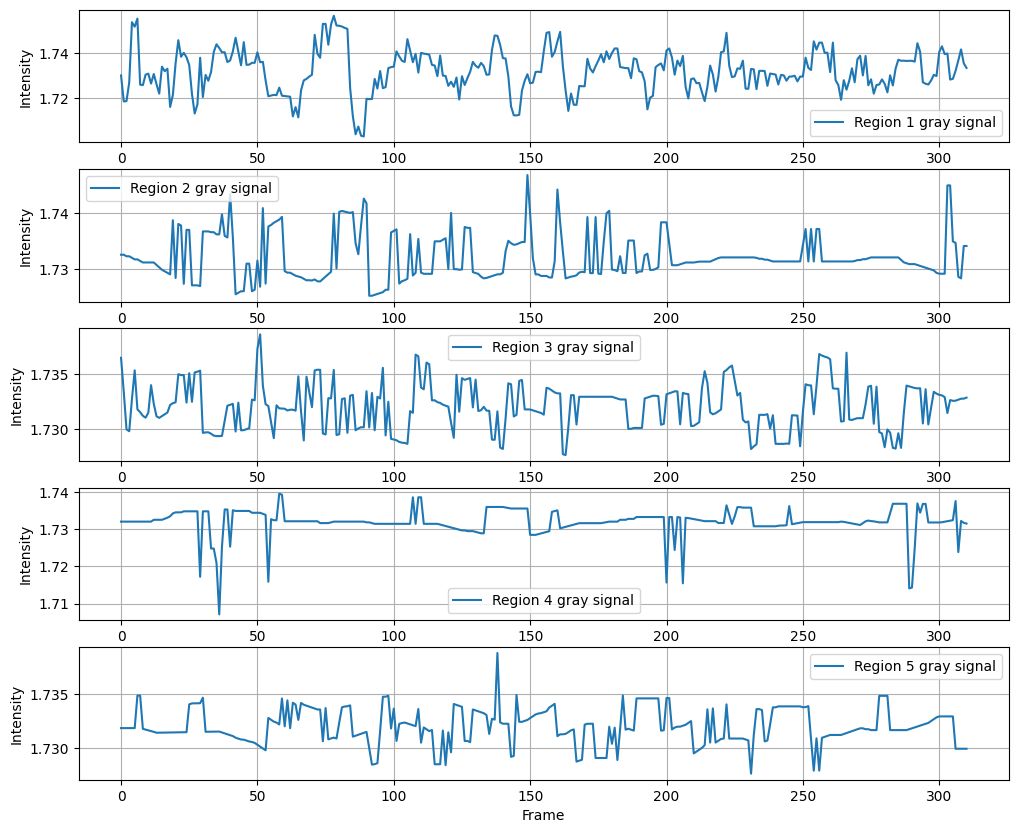

In [1]:
# ------------------------------------------------------------------
#  extra block – CHROM pulse estimate per region
# ------------------------------------------------------------------
from scipy.signal import butter, filtfilt, welch
import numpy as np
import matplotlib.pyplot as plt


cut = 25
fps = 30
n_regions = 5

#load motion-processed trajectories

RGB_arr = np.load('/Users/henryschnieders/Documents/Research/My_Data/rgb_per_region.npy', allow_pickle=True)


print(RGB_arr.shape)

RGB_arr = RGB_arr[:, cut:-cut, :]

# # --- organise by region -------------------------------------------------
# region_tracks = [[] for _ in range(n_regions)]        # list of signals

# ------------------------------------------------------------------
# 1.  Add SNR to the CHROM helper
# ------------------------------------------------------------------
from scipy.signal import butter, filtfilt, welch
import numpy as np

def chrom_bpm(R, G, B, fps, f_lo=0.7, f_hi=4.0, snr_bw=0.1):
    """
    CHROM pulse estimation with SNR.
    Returns (bpm_estimate, snr_dB, pulse_trace).
      • snr_dB uses the power ratio within ±snr_bw Hz of the peak (and its 2× harmonic)
        versus the remaining band-pass power, in dB.
    """
    # ---------- detrend (1.6-s moving mean) ----------
    win = max(1, int(round(1.6 * fps)))
    kernel = np.ones(win) / win
    def detrend(x):
        ok = ~np.isnan(x)
        local  = np.convolve(np.where(ok, x, 0.0), kernel, 'same')
        counts = np.convolve(ok.astype(float),        kernel, 'same')
        return np.where(counts > 0, x - local / counts, 0.0)
    r, g, b = map(detrend, (R, G, B))

    # ---------- chrominance projection ----------
    Sx, Sy = 3*r - 2*g, 1.5*r + g - 1.5*b
    alpha  = np.nanstd(Sx) / (np.nanstd(Sy) + 1e-8)
    X      = Sx - alpha*Sy

    # ---------- 0.7–4 Hz band-pass ----------
    b_f, a_f = butter(3, [f_lo/(fps/2), f_hi/(fps/2)], btype='band')
    Xf       = filtfilt(b_f, a_f, X)

    # ---------- Welch spectrum & peak ----------
    f, Pxx = welch(Xf, fs=fps, nperseg=min(512, len(Xf)))
    band    = (f >= f_lo) & (f <= f_hi)
    if not band.any():
        return np.nan, np.nan, Xf
    f_band, P_band = f[band], Pxx[band]
    f_peak = f_band[np.argmax(P_band)]
    bpm    = f_peak * 60.0

    # ---------- simple SNR (±snr_bw Hz around 1× & 2× peaks) ----------
    sig_mask = (np.abs(f_band - f_peak)     <= snr_bw) | \
               (np.abs(f_band - 2.0*f_peak) <= snr_bw)
    P_sig  = P_band[sig_mask].sum()
    P_noise = P_band[~sig_mask].sum() + 1e-12
    snr_db = 10.0 * np.log10(P_sig / P_noise)

    return bpm, snr_db, Xf



# ------------------ load saved RGB means -------------------------
n_regions , T_trim, _ = RGB_arr.shape
fps = 30

print(RGB_arr.shape)

# ------------------------------------------------------------------
# 2.  Run CHROM per region (now capturing SNR)
# ------------------------------------------------------------------
chrom_bpm_est, chrom_snr_est, chrom_traces = [], [], []

for reg in range(n_regions):
    R, G, B = RGB_arr[reg].T          # (T_trim,) each
    bpm, snr_db, tr = chrom_bpm(R, G, B, fps)
    chrom_bpm_est.append(bpm)
    chrom_snr_est.append(snr_db)
    chrom_traces.append(tr)


def build_gray(rgb_arr):
    """
    Return per-frame Euclidean norm ‖(R,G,B)‖₂.

    Parameters
    ----------
    rgb_arr : ndarray shape (T, 3)  uint8 / float
        One RGB sample per frame.

    Returns
    -------
    gray_like : ndarray shape (T,)  float32
        Intensity proxy √(R²+G²+B²) for every frame.
    """
    rgb_arr = rgb_arr.astype(np.float32)
    return np.linalg.norm(rgb_arr, axis=1).astype(np.float32)

# ------------------ plot -----------------------------------------
plt.figure(figsize=(12, 10))
for r, (tr, bpm, snr_db) in enumerate(zip(chrom_traces,
                                          chrom_bpm_est,
                                          chrom_snr_est)):
    plt.subplot(n_regions, 1, r + 1)
    plt.plot(tr, lw=0.9,
             label=f"Region {r+1}: HR ≈ {bpm:5.1f} BPM | SNR ≈ {snr_db:4.1f} dB")
    plt.ylabel("CHROM"); plt.grid(True)
    if r == n_regions - 1:
        plt.xlabel("Frame")
    plt.legend()

plt.show()

plt.figure(figsize=(12, 10))
for r in range(n_regions):
    plt.subplot(n_regions, 1, r + 1)
    plt.plot(build_gray(RGB_arr[r]), label=f'Region {r + 1} gray signal')

    plt.ylabel('Intensity')
    plt.grid(True)
    if r == n_regions - 1:
        plt.xlabel('Frame')
    plt.legend()

plt.show()


# First Try: Optimization of S_x via theta march

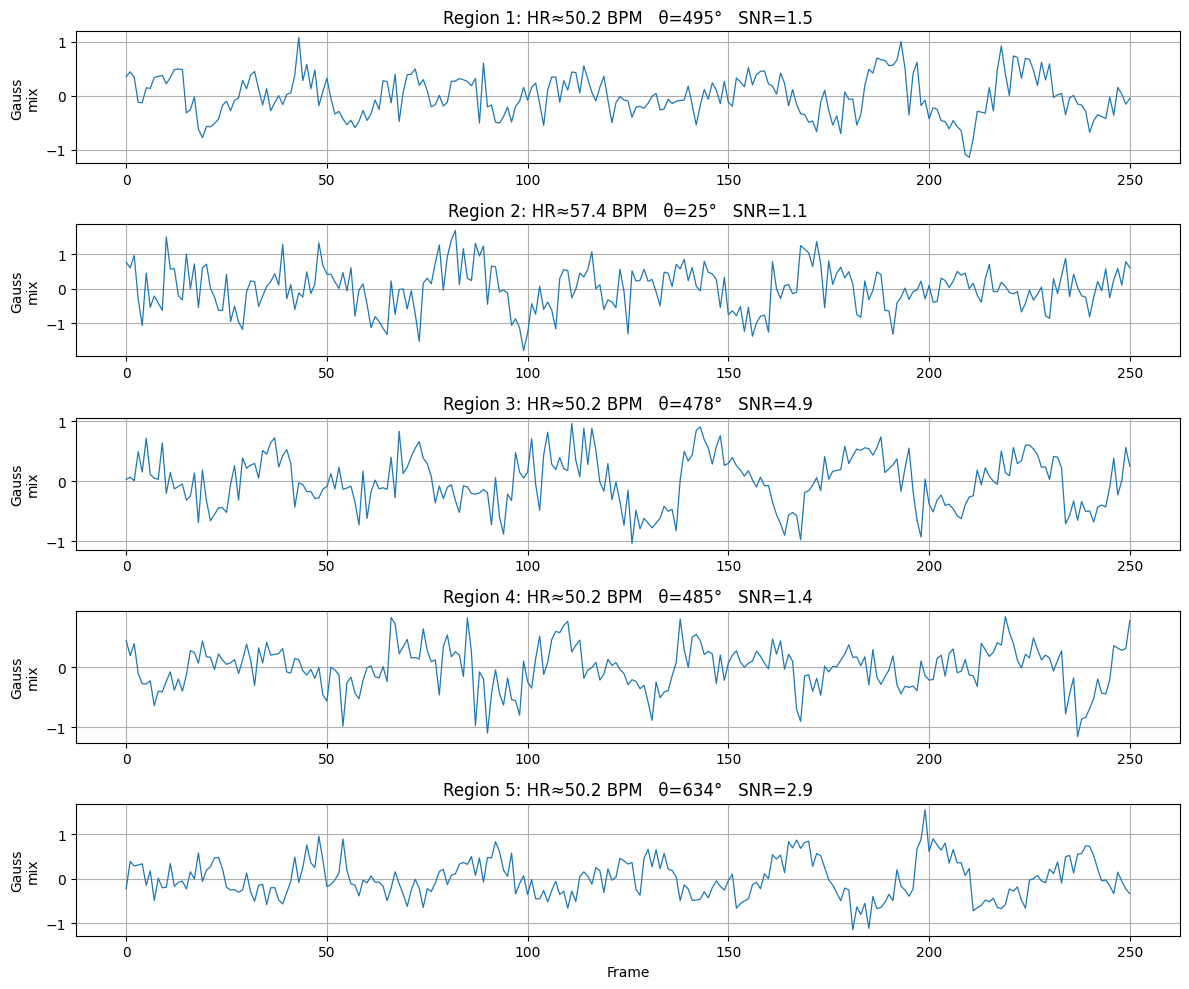

In [63]:
import numpy as np, scipy.signal as sig, scipy.optimize as opt
import matplotlib.pyplot as plt




cut = 25
fps = 30
n_regions = 5



# n_frames  = len(trajectories_db[0]['rgb'])            # all tracks full-length


# # ---------- rebuild RGB_signals directly ---------------------------
# RGB_signals = []

# for reg in range(n_regions):
#     tracks = [tr for tr in trajectories_db if tr['region']==reg]
#     if not tracks:
#         RGB_signals.append((np.full(n_frames-2*cut, np.nan),)*3)
#         continue

#     # stack: P×T×3
#     cube = np.stack([tr['rgb'] for tr in tracks])       # P×T×3
#     # simple mean across tracks (no φ-mask here)
#     R = cube[...,0].mean(axis=0)[cut:-cut]
#     G = cube[...,1].mean(axis=0)[cut:-cut]
#     B = cube[...,2].mean(axis=0)[cut:-cut]
#     RGB_signals.append((R, G, B))

def bpm_and_snr(x, fs, f_lo=0.7, f_hi=4.0):
    f, P = sig.welch(x, fs=fs, nperseg=min(512, len(x)))
    band = (f >= f_lo) & (f <= f_hi)
    if not np.any(band): return np.nan, 0.0
    peak_f = f[band][np.argmax(P[band])]
    mask   = (f >= peak_f-0.2) & (f <= peak_f+0.2)
    snr = P[mask].sum() / (P[band].sum() - P[mask].sum() + 1e-8)
    return peak_f*60, snr
# ---- helper: detrend with NaN-aware moving mean ----
def detrend_nan(v, win):
    ok = ~np.isnan(v)
    filled = np.where(ok, v, 0.0)
    kernel = np.ones(win, float) / win
    local  = np.convolve(filled, kernel, 'same')
    counts = np.convolve(ok.astype(float), kernel, 'same')
    return v - np.where(counts > 0, local / counts, 0.0)

def optimise_axis(R,G,B, fs, win_len=1.6):
    win = max(1, int(round(win_len*fs)))
    r,g,b = (detrend_nan(v, win) for v in (R,G,B))

    Sx = 3*r - 2*g
    Sy = 1.5*r + g - 1.5*b

    def quality(theta):
        x = np.cos(theta)*Sx + np.sin(theta)*Sy
        bpm, snr = bpm_and_snr(sig.detrend(x), fs)
        return -snr

    θ = opt.brent(quality, brack=(0, np.pi))
    x_opt = np.cos(θ)*Sx + np.sin(θ)*Sy
    bpm, snr = bpm_and_snr(sig.detrend(x_opt), fs)
    return θ, bpm, snr, x_opt

# ------ run optimisation ------
opt_thetas, opt_bpm, opt_snr, opt_traces = [], [], [], []


# # ------------------ load saved RGB means -------------------------
# n_regions , T_trim, _ = RGB_arr.shape
# fps = 30

# print(RGB_arr.shape)

# # ------------------ run CHROM ------------------------------------
# chrom_bpm_est , chrom_traces = [] , []

# for reg in range(n_regions):
#     # unpack this region’s RGB vectors                    (T_trim,)
#     R , G , B = RGB_arr[reg].T        # transpose = shape (3,T_trim) → three 1-D arrays
#     bpm , tr  = chrom_bpm(R, G, B, fps)
#     chrom_bpm_est.append(bpm)
#     chrom_traces.append(tr)



for reg in range(n_regions):
    R , G , B = RGB_arr[reg].T
    if np.all(np.isnan(R)):
        opt_thetas.append(np.nan); opt_bpm.append(np.nan); opt_snr.append(np.nan)
        opt_traces.append(np.full_like(R, np.nan)); continue
    θ,bpm,snr,x = optimise_axis(R,G,B, fs=fps)
    opt_thetas.append(θ); opt_bpm.append(bpm); opt_snr.append(snr); opt_traces.append(x)

# ------ plot ------
plt.figure(figsize=(12,10))
for r,(tr,bpm,θ) in enumerate(zip(opt_traces,opt_bpm,opt_thetas)):
    plt.subplot(5,1,r+1)
    plt.plot(tr, lw=0.9)
    plt.ylabel("Gauss\nmix")
    plt.title(f"Region {r+1}: HR≈{bpm:.1f} BPM   θ={θ*180/np.pi:.0f}°   SNR={opt_snr[r]:.1f}")
    plt.grid(True)
    if r==4: plt.xlabel("Frame")
plt.tight_layout()
plt.savefig('/Users/henryschnieders/Desktop/gauss_mix_signal_per_region.png', dpi=300)
plt.show()


# Iteration 2: Evolution Algorithm with SNR, BPM metrics

Optimal coefficients (A,B,C,D,E): [3.126 1.502 1.301 1.248 0.878]
Final −BPM: 43.02788844621514
Optimal coefficients (A,B,C,D,E): [2.538 2.364 2.062 0.461 1.638]
Final −BPM: 50.199203187250994
Optimal coefficients (A,B,C,D,E): [3.  2.  1.5 1.  1.5]
Final −BPM: 50.199203187250994
Optimal coefficients (A,B,C,D,E): [3.  2.  1.5 1.  1.5]
Final −BPM: 50.199203187250994
Optimal coefficients (A,B,C,D,E): [3.  2.  1.5 1.  1.5]
Final −BPM: 43.02788844621514


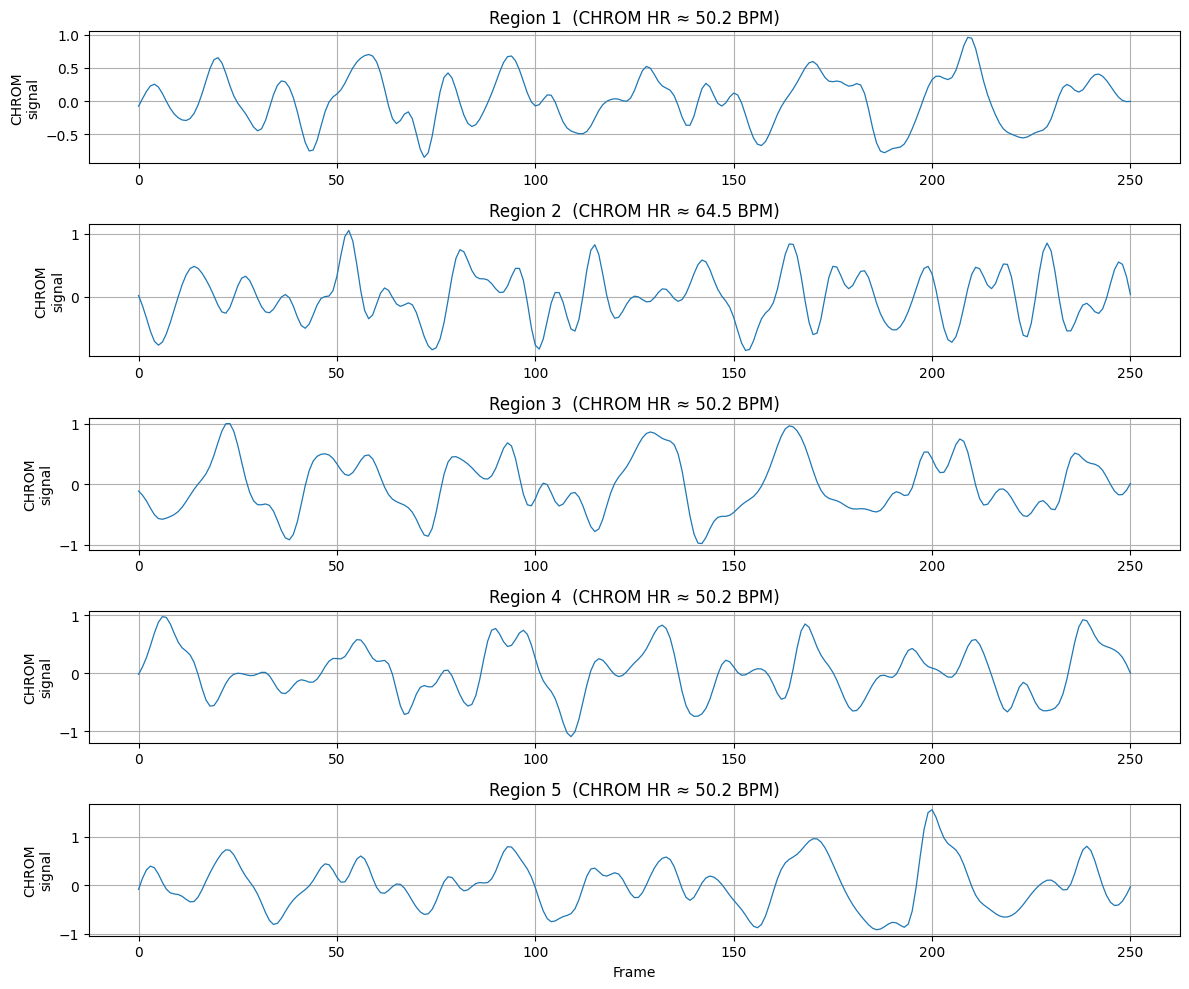

In [67]:
import numpy as np, scipy.signal as sig, random, math
from scipy.signal import butter, filtfilt, welch

def chrom_bpm(R, G, B, fps, L=3, M = 2, N = 1.5, O = 1, P =1.5, f_lo=0.7, f_hi=4.0):
    
    """
    One-shot CHROM on 1-D RGB traces → (BPM, pulse_trace).
    R,G,B are numpy arrays of equal length (NaN ok).
    """
    # 1) detrend with a 1.6-s moving mean  (van der Kooij, 2013)
    win = int(round(1.6 * fps))
    if win < 1: win = 1
    kernel = np.ones(win) / win

    def detrend(x):
        ok = ~np.isnan(x)
        filled = np.where(ok, x, 0.0)
        local  = np.convolve(filled, kernel, 'same')
        counts = np.convolve(ok.astype(float), kernel, 'same')
        return np.where(counts > 0, x - local / counts, 0.0)

    r = detrend(R); g = detrend(G); b = detrend(B)

    # 2) chrominance projection
    Sx = L*r - M*g
    Sy = N*r + O*g - P*b
    alpha = np.nanstd(Sx) / (np.nanstd(Sy) + 1e-8)
    X = Sx - alpha * Sy   # minus sign = CHROM variant

    # 3) band-pass 0.7–4.0 Hz  (≈42–240 BPM)
    b,a = butter(3, [f_lo/(fps/2), f_hi/(fps/2)], btype='band')
    Xf  = filtfilt(b, a, X)

    # 4) FFT / Welch peak   → BPM
    f, Pxx = welch(Xf, fs=fps, nperseg=min(512, len(Xf)))
    mask   = (f >= f_lo) & (f <= f_hi)
    if not np.any(mask):
        return np.nan, Xf
    bpm = f[mask][np.argmax(Pxx[mask])] * 60.0
    return bpm, Xf

# ------------------------------------------------------------------
#  helper – SNR & BPM for a single chrominance mix
# ------------------------------------------------------------------
def pulse_quality(R, G, B, coeffs, fs, band=(0.7, 4.0)):
    A,B,C,D,E = coeffs
    Sx =  A*R - B*G
    Sy =  C*R + D*G - E*B
    X  = Sx - (np.nanstd(Sx)/(np.nanstd(Sy)+1e-8)) * Sy    # CHROM-style mix

    # detrend + band-pass (same as before)
    Xd  = sig.detrend(X, type='linear')
    b,a = sig.butter(3, [band[0]/(fs/2), band[1]/(fs/2)], btype='band')
    Xf  = sig.filtfilt(b, a, Xd)

    f, P = sig.welch(Xf, fs=fs, nperseg=min(512, len(Xf)))
    band_m = (f >= band[0]) & (f <= band[1])
    if not np.any(band_m): return np.nan, 0.0
    f_peak = f[band_m][np.argmax(P[band_m])]
    mask   = (f >= f_peak-0.2) & (f <= f_peak+0.2)
    snr    = P[mask].sum() / (P[band_m].sum() - P[mask].sum() + 1e-9)
    bpm    = f_peak * 60.0
    return bpm, snr

# ------------------------------------------------------------------
#  evolution loop  (one region at a time – extend as you like)
# ------------------------------------------------------------------
def evolve_coeffs(R, G, B, fs, metric='snr', generations=80,
                  pop_size=30, σ_init=0.3, σ_decay=0.98):
    """
    metric = 'snr'  → maximise SNR
           = 'bpm'  → minimise BPM (push towards fundamental)
    """
    base = np.array([3.0, 2.0, 1.5, 1.0, 1.5])           # CHROM seed
    pop  = [base.copy() for _ in range(pop_size)]
    σ    = σ_init

    def score(coeff):
        bpm, snr = pulse_quality(R,G,B, coeff, fs)
        return snr if metric=='snr' else -bpm            # higher is better

    best = max(pop, key=score)
    best_val = score(best)

    for gen in range(generations):
        new_pop = []
        for _ in range(pop_size):
            child = best + np.random.normal(0, σ, size=5)
            # clamp to positive coeffs to avoid sign-flips in Sx/Sy
            child = np.clip(child, 0.05, 6.0)
            new_pop.append(child)
        pop = new_pop
        cand = max(pop, key=score)
        cand_val = score(cand)
        if cand_val > best_val:
            best, best_val = cand, cand_val
        σ *= σ_decay       # gradually fine-tune
    return best, best_val

# # ------------- example use on Region 1 ----------------------------
# R,G,B = RGB_signals[0]        # pick a region
# coeff_opt, val_opt = evolve_coeffs(R, G, B, fs=fps, metric='bpm',
#                                    generations=1000, pop_size=50)
# print("Optimal coefficients (A,B,C,D,E):", coeff_opt.round(3))
# print("Final SNR:" if val_opt>0 else "Final −BPM:", abs(val_opt))



# for reg in range(n_regions):
#     R , G , B = RGB_arr[reg].T
#     if np.all(np.isnan(R)):
#         opt_thetas.append(np.nan); opt_bpm.append(np.nan); opt_snr.append(np.nan)
#         opt_traces.append(np.full_like(R, np.nan)); continue
#     θ,bpm,snr,x = optimise_axis(R,G,B, fs=fps)
#     opt_thetas.append(θ); opt_bpm.append(bpm); opt_snr.append(snr); opt_traces.append(x)

# ---------- run CHROM ----------------------------------------------
chrom_bpm_est = []; chrom_traces=[]

for reg in range(n_regions):
    # unpack this region’s RGB vectors                    (T_trim,)
    R , G , B = RGB_arr[reg].T        # transpose = shape (3,T_trim) → three 1-D arrays

    coeff_opt, val_opt = evolve_coeffs(R, G, B, fs=fps, metric='bpm',
                                       generations=1000, pop_size=50)
    print("Optimal coefficients (A,B,C,D,E):", coeff_opt.round(3))
    print("Final SNR:" if val_opt>0 else "Final −BPM:", abs(val_opt))

    bpm , tr  = chrom_bpm(R, G, B, fps, L = coeff_opt[0], M = coeff_opt[1], N = coeff_opt[2], 
                          O = coeff_opt[3], P = coeff_opt[4])
    chrom_bpm_est.append(bpm)
    chrom_traces.append(tr)


# ---------- plot ----------------------------------------------------
plt.figure(figsize=(12,10))
for r, (tr, bpm) in enumerate(zip(chrom_traces, chrom_bpm_est)):
    plt.subplot(5,1,r+1)
    plt.plot(tr, lw=0.9)
    plt.ylabel("CHROM\nsignal")
    plt.title(f"Region {r+1}  (CHROM HR ≈ {bpm:.1f} BPM)")
    plt.grid(True)
    if r==4: plt.xlabel("Frame")
plt.tight_layout()
plt.savefig('/Users/henryschnieders/Desktop/chrom_signal_per_region.png', dpi=300)


Optimal coefficients (A,B,C,D,E): [2.281 2.076 1.661 0.185 2.345]
Final SNR: 7.56 Final −BPM: 57.37
region =  1


Optimal coefficients (A,B,C,D,E): [2.07  2.486 1.68  1.088 1.328]
Final SNR: 4.94 Final −BPM: 64.54
region =  2


Optimal coefficients (A,B,C,D,E): [2.608 2.348 1.642 1.507 1.798]
Final SNR: 1.79 Final −BPM: 57.37
region =  3


Optimal coefficients (A,B,C,D,E): [2.07  2.165 2.456 0.898 0.874]
Final SNR: 5.1 Final −BPM: 57.37
region =  4


Optimal coefficients (A,B,C,D,E): [3.577 2.421 0.713 0.167 0.854]
Final SNR: 3.07 Final −BPM: 57.37
region =  5




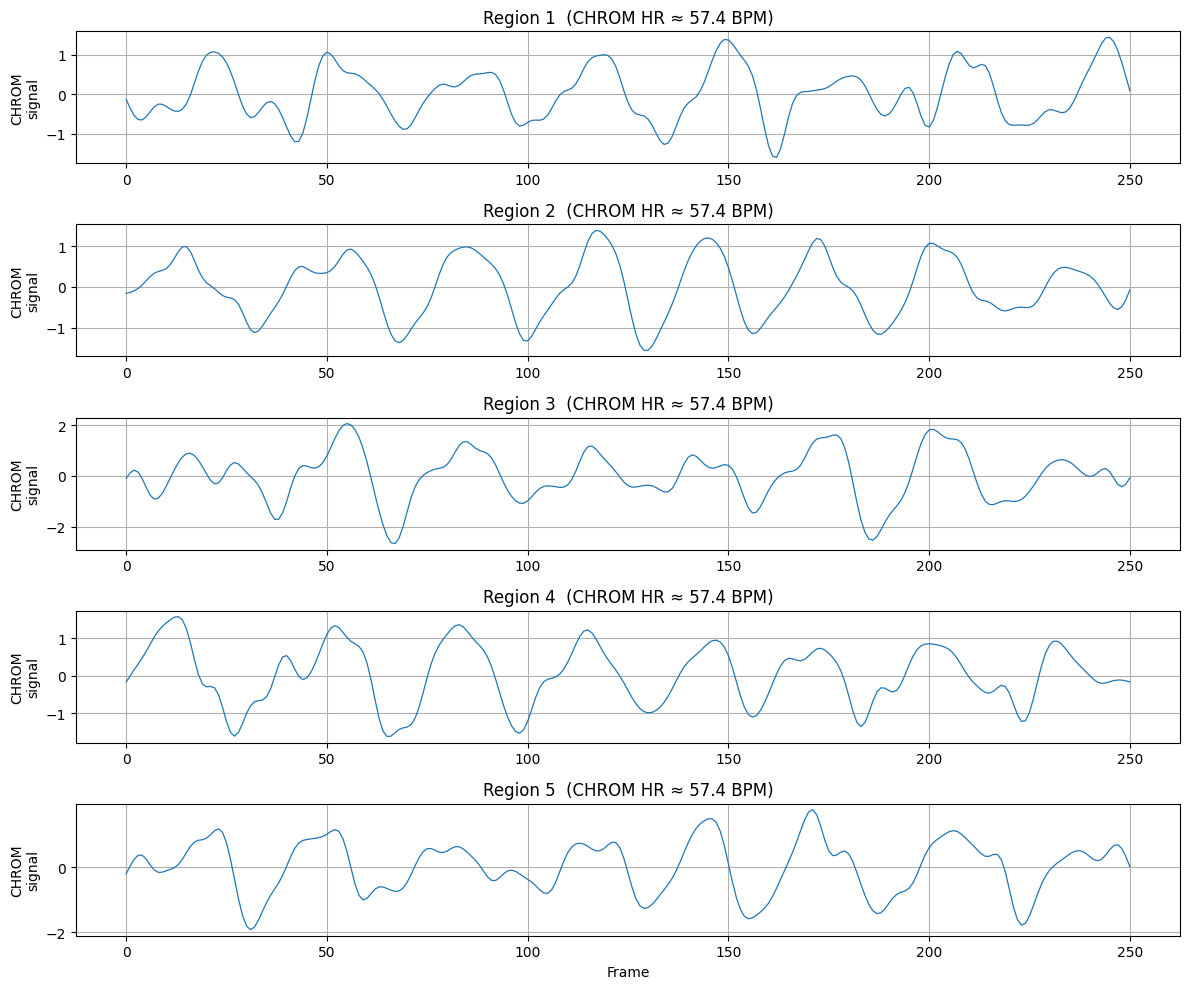

In [36]:
import numpy as np, scipy.signal as sig, random, math
from scipy.signal import butter, filtfilt, welch

def chrom_bpm(R, G, B, fps, L=3, M = 2, N = 1.5, O = 1, P =1.5, f_lo=0.7, f_hi=4.0):
    
    """
    One-shot CHROM on 1-D RGB traces → (BPM, pulse_trace).
    R,G,B are numpy arrays of equal length (NaN ok).
    """
    # 1) detrend with a 1.6-s moving mean  (van der Kooij, 2013)
    win = int(round(1.6 * fps))
    if win < 1: win = 1
    kernel = np.ones(win) / win

    def detrend(x):
        ok = ~np.isnan(x)
        filled = np.where(ok, x, 0.0)
        local  = np.convolve(filled, kernel, 'same')
        counts = np.convolve(ok.astype(float), kernel, 'same')
        return np.where(counts > 0, x - local / counts, 0.0)

    r = detrend(R); g = detrend(G); b = detrend(B)

    # 2) chrominance projection
    Sx = L*r - M*g
    Sy = N*r + O*g - P*b
    alpha = np.nanstd(Sx) / (np.nanstd(Sy) + 1e-8)
    X = Sx - alpha * Sy   # minus sign = CHROM variant

    # 3) band-pass 0.7–4.0 Hz  (≈42–240 BPM)
    b,a = butter(3, [f_lo/(fps/2), f_hi/(fps/2)], btype='band')
    Xf  = filtfilt(b, a, X)

    # 4) FFT / Welch peak   → BPM
    f, Pxx = welch(Xf, fs=fps, nperseg=min(512, len(Xf)))
    mask   = (f >= f_lo) & (f <= f_hi)
    if not np.any(mask):
        return np.nan, Xf
    bpm = f[mask][np.argmax(Pxx[mask])] * 60.0
    return bpm, Xf

# ------------------------------------------------------------------
#  helper – SNR & BPM for a single chrominance mix
# ------------------------------------------------------------------
def pulse_quality(R, G, B, coeffs, fs, band=(0.7, 4.0)):
    A,B,C,D,E = coeffs
    Sx =  A*R - B*G
    Sy =  C*R + D*G - E*B
    X  = Sx - (np.nanstd(Sx)/(np.nanstd(Sy)+1e-8)) * Sy    # CHROM-style mix

    # detrend + band-pass (same as before)
    Xd  = sig.detrend(X, type='linear')
    b,a = sig.butter(3, [band[0]/(fs/2), band[1]/(fs/2)], btype='band')
    Xf  = sig.filtfilt(b, a, Xd)

    f, P = sig.welch(Xf, fs=fs, nperseg=min(512, len(Xf)))
    band_m = (f >= band[0]) & (f <= band[1])
    if not np.any(band_m): return np.nan, 0.0
    f_peak = f[band_m][np.argmax(P[band_m])]
    mask   = (f >= f_peak-0.2) & (f <= f_peak+0.2)
    snr    = P[mask].sum() / (P[band_m].sum() - P[mask].sum() + 1e-9)
    bpm    = f_peak * 60.0
    return bpm, snr

# ------------------------------------------------------------------
#  evolution loop  (one region at a time – extend as you like)
# ------------------------------------------------------------------
def evolve_coeffs(R, G, B, fs, metric='snr', generations=80,
                  pop_size=30, σ_init=0.3, σ_decay=0.99):
    """
    metric = 'snr'  → maximise SNR
           = 'bpm'  → minimise BPM (push towards fundamental)
    """
    base = np.array([3.0, 2.0, 1.5, 1.0, 1.5])           # CHROM seed
    pop  = [base.copy() for _ in range(pop_size)]
    σ    = σ_init

    def score(coeff):
        bpm, snr = pulse_quality(R,G,B, coeff, fs)
        return snr if metric=='snr' else -bpm            # higher is better
    
    def score_final(coeff):
        bpm, snr = pulse_quality(R,G,B, coeff, fs)
        return [snr, -bpm]           # higher is better

    best = max(pop, key=score)
    best_val = score(best)

    for gen in range(generations):
        new_pop = []
        for _ in range(pop_size):
            child = best + np.random.normal(0, σ, size=5)
            # clamp to positive coeffs to avoid sign-flips in Sx/Sy
            child = np.clip(child, 0.05, 6.0)
            new_pop.append(child)
        pop = new_pop
        cand = max(pop, key=score)
        cand_val = score(cand)
        if cand_val > best_val:
            best, best_val = cand, cand_val
        σ *= σ_decay       # gradually fine-tune


    best_val = score_final(best)

    return best, best_val

# # ------------- example use on Region 1 ----------------------------
# R,G,B = RGB_signals[0]        # pick a region
# coeff_opt, val_opt = evolve_coeffs(R, G, B, fs=fps, metric='bpm',
#                                    generations=1000, pop_size=50)
# print("Optimal coefficients (A,B,C,D,E):", coeff_opt.round(3))
# print("Final SNR:" if val_opt>0 else "Final −BPM:", abs(val_opt))



# ---------- run CHROM ----------------------------------------------
chrom_bpm_est = []; chrom_traces=[]
for r, (R,G,B) in enumerate(RGB_signals):

    coeff_opt, val_opt = evolve_coeffs(R, G, B, fs=fps, metric='snr',
                                    generations=500, pop_size=100)
    
    print("Optimal coefficients (A,B,C,D,E):", coeff_opt.round(3))
    print(f"Final SNR: {round(val_opt[0], 2)} Final −BPM: {round(abs(val_opt[1]),2)}")
    print('region = ', r+1)
    print('\n')
    
    bpm, trace = chrom_bpm(R, G, B, fps, L = coeff_opt[0], M = coeff_opt[1], N = coeff_opt[2],
                           O = coeff_opt[3], P = coeff_opt[4])
    chrom_bpm_est.append(bpm); chrom_traces.append(trace)

# ---------- plot ----------------------------------------------------
plt.figure(figsize=(12,10))
for r, (tr, bpm) in enumerate(zip(chrom_traces, chrom_bpm_est)):
    plt.subplot(5,1,r+1)
    plt.plot(tr, lw=0.9)
    plt.ylabel("CHROM\nsignal")
    plt.title(f"Region {r+1}  (CHROM HR ≈ {bpm:.1f} BPM)")
    plt.grid(True)
    if r==4: plt.xlabel("Frame")
plt.tight_layout()
plt.savefig('/Users/henryschnieders/Desktop/chrom_signal_per_region.png', dpi=300)


# Add signals at each step to boost SNR

Best coeffs: [0.05  4.381 6.    5.352 0.05 ]
Composite BPM ≈ 57.4  (SNR=7.55)   traces stacked: 251


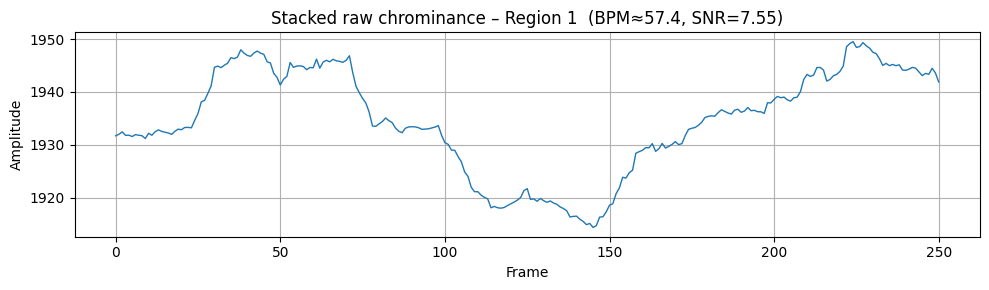

Best coeffs: [2.349 3.438 1.157 1.546 1.31 ]
Composite BPM ≈ 64.5  (SNR=5.28)   traces stacked: 251


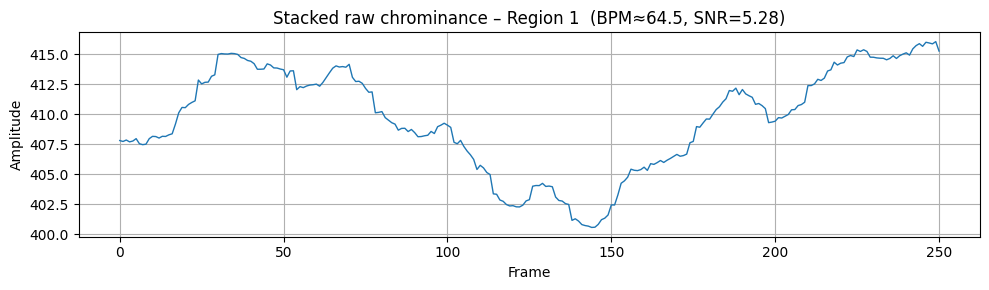

Best coeffs: [2.462 1.676 3.067 0.415 2.217]
Composite BPM ≈ 57.4  (SNR=2.15)   traces stacked: 251


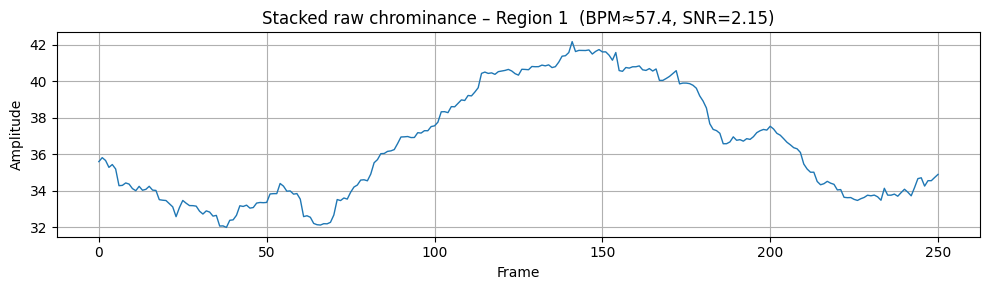

Best coeffs: [1.78  3.592 6.    6.    0.05 ]
Composite BPM ≈ 57.4  (SNR=5.09)   traces stacked: 251


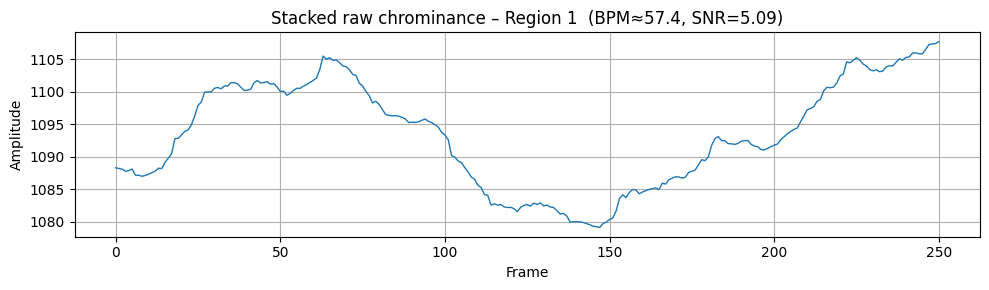

Best coeffs: [0.213 1.569 6.    6.    0.05 ]
Composite BPM ≈ 57.4  (SNR=3.07)   traces stacked: 251


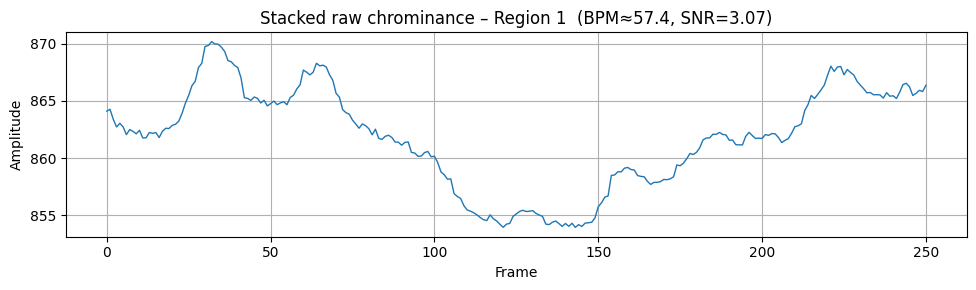

In [23]:
import numpy as np, scipy.signal as sig, scipy.optimize as opt



# ---------------------------------------------------------------
# helper – returns BPM, SNR *and* the raw chrominance trace X_raw
# ---------------------------------------------------------------
def pulse_metrics(R, G, B, coeffs, fs, band=(0.7, 4.0)):
    A,Bc,C,D,E = coeffs        # (rename B→Bc to avoid shadowing)
    Sx =  A*R - Bc*G
    Sy =  C*R + D*G - E*B
    alpha = np.nanstd(Sx) / (np.nanstd(Sy)+1e-8)
    X_raw = Sx - alpha * Sy    # no filtering yet

    # detrend + band-pass for metric only
    Xd  = sig.detrend(X_raw, type='linear')
    b,a = sig.butter(3, [band[0]/(fs/2), band[1]/(fs/2)], btype='band')
    Xbp = sig.filtfilt(b, a, Xd)

    f, P = sig.welch(Xbp, fs=fs, nperseg=min(512, len(Xbp)))
    band_m = (f >= band[0]) & (f <= band[1])
    if not np.any(band_m):
        return np.nan, 0.0, X_raw
    fpk = f[band_m][np.argmax(P[band_m])]
    pmask = (f >= fpk-0.2) & (f <= fpk+0.2)
    snr = P[pmask].sum() / (P[band_m].sum() - P[pmask].sum() + 1e-9)
    bpm = fpk*60
    return bpm, snr, X_raw

# ---------------------------------------------------------------
# evolutionary search that stores every *improving* raw trace
# ---------------------------------------------------------------
def evolve_and_stack(R, G, B, fs, metric='snr',
                     generations=10000, pop_size=50,
                     σ_init=0.3, σ_decay=0.98):

    base = np.array([3.0, 2.0, 1.5, 1.0, 1.5])        # CHROM seed
    pop  = [base.copy() for _ in range(pop_size)]
    σ    = σ_init

    # evaluate seed
    bpm0, snr0, x_best = pulse_metrics(R,G,B, base, fs)
    best, best_val = base, (snr0 if metric=='snr' else -bpm0)
    bank = [x_best]          # store first trace

    for _ in range(generations):
        new_pop = []
        for _ in range(pop_size):
            child = best + np.random.normal(0, σ, size=5)
            child = np.clip(child, 0.05, 6.0)          # keep coeffs positive
            new_pop.append(child)
        pop = new_pop

        # pick the fittest candidate in this gen
        vals  = []
        traces= []
        for cand in pop:
            bpm, snr, x = pulse_metrics(R,G,B, cand, fs)
            vals.append( snr if metric=='snr' else -bpm )
            traces.append(x)
        idx = int(np.argmax(vals))
        if vals[idx] > best_val:               # improvement found
            best, best_val = pop[idx], vals[idx]
            # align sign so peaks are coherent with current best trace
            corr = np.nanmean(bank[-1]*traces[idx])
            bank.append(traces[idx] if corr>=0 else -traces[idx])
        σ *= σ_decay

    # --- combine stored traces ---------------------------------
    stacked = np.nanmean(np.vstack(bank), axis=0)

    # compute final BPM & SNR on the stacked trace
    b,a = sig.butter(3, [0.7/(fs/2), 4.0/(fs/2)], btype='band')
    Xbp = sig.filtfilt(b, a, sig.detrend(stacked))
    f,P = sig.welch(Xbp, fs=fs, nperseg=min(512,len(Xbp)))
    band = (f>=0.7)&(f<=4.0)
    fpk = f[band][np.argmax(P[band])]
    bpm_final = fpk*60
    snr_final = (P[(f>=fpk-0.2)&(f<=fpk+0.2)].sum() /
                 (P[band].sum()-P[(f>=fpk-0.2)&(f<=fpk+0.2)].sum()+1e-9))

    return best, bpm_final, snr_final, stacked

# ------------- run on Region 1 as a demo -------------------------

for reg in range(n_regions):
    R,G,B = RGB_signals[reg]
    coeff, bpm, snr, combo = evolve_and_stack(R,G,B, fs=fps, metric='snr')

    print("Best coeffs:", coeff.round(3))
    print(f"Composite BPM ≈ {bpm:.1f}  (SNR={snr:.2f})   traces stacked: {len(combo)}")

    plt.figure(figsize=(10,3))
    plt.plot(combo, lw=1)
    plt.title(f"Stacked raw chrominance – Region 1  (BPM≈{bpm:.1f}, SNR={snr:.2f})")
    plt.xlabel("Frame"); plt.ylabel("Amplitude"); plt.grid(True)
    plt.tight_layout(); plt.show()

plt.show()

# Signal stacking: evenly distributed in RGB

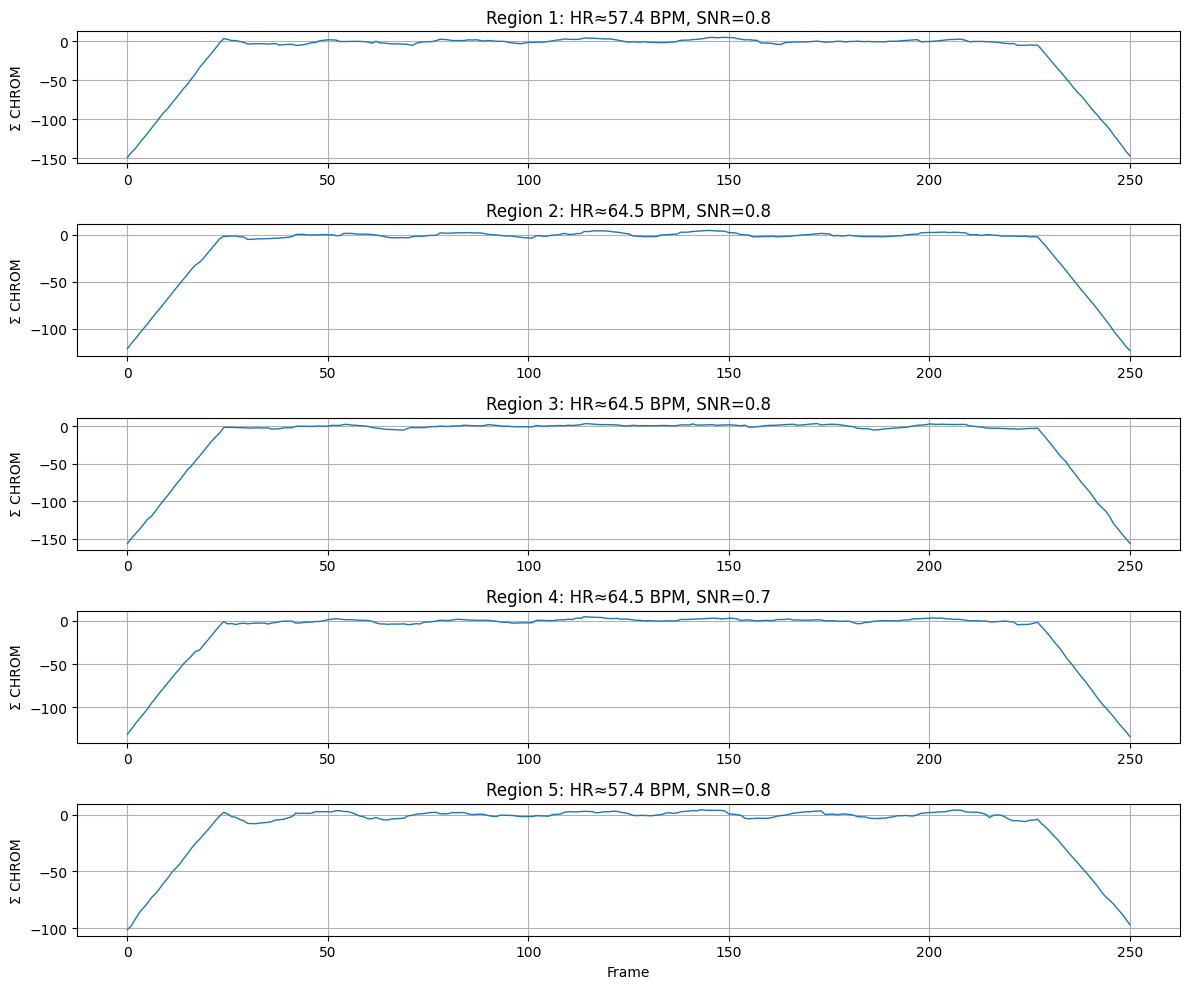

In [32]:
import numpy as np, scipy.signal as sig
from scipy.signal import butter, filtfilt, welch

cut = 25
fps = 30
trajectories_db = np.load('/Users/henryschnieders/Documents/Research/My_Data/pixel_trajectories_20250607_225214.npz', allow_pickle=True)['trajectories'].tolist()

n_regions = 5
n_frames  = len(trajectories_db[0]['rgb'])            # all tracks full-length


# ---------- rebuild RGB_signals directly ---------------------------
RGB_signals = []

for reg in range(n_regions):
    tracks = [tr for tr in trajectories_db if tr['region']==reg]
    if not tracks:
        RGB_signals.append((np.full(n_frames-2*cut, np.nan),)*3)
        continue

    # stack: P×T×3
    cube = np.stack([tr['rgb'] for tr in tracks])       # P×T×3
    # simple mean across tracks (no φ-mask here)
    R = cube[...,0].mean(axis=0)[cut:-cut]
    G = cube[...,1].mean(axis=0)[cut:-cut]
    B = cube[...,2].mean(axis=0)[cut:-cut]
    RGB_signals.append((R, G, B))



# ------------ NaN-aware detrend -----------------------------------
def detrend_nan(v, win):
    ok = ~np.isnan(v)
    filled = np.where(ok, v, 0.0)
    k = np.ones(win)/win
    local  = np.convolve(filled, k, 'same')
    counts = np.convolve(ok.astype(float), k, 'same')
    return v - np.where(counts>0, local/counts, 0.0)

# ------------ helper: CHROM mix at θ, returns raw & SNR -----------
def chrom_trace_theta(R,G,B, theta, fs, band=(0.7,4.0)):
    win = max(1, int(round(1.6*fs)))
    r,g,b = (detrend_nan(v, win) for v in (R,G,B))

    Sx = 3*r - 2*g
    Sy = 1.5*r + g - 1.5*b
    X  = np.cos(theta)*Sx + np.sin(theta)*Sy          # raw

    # band-pass for metrics
    b,a = butter(3, [band[0]/(fs/2), band[1]/(fs/2)], btype='band')
    Xf  = filtfilt(b, a, sig.detrend(X))

    f,P = welch(Xf, fs=fs, nperseg=min(512,len(Xf)))
    mask = (f>=band[0])&(f<=band[1])
    if not np.any(mask): return np.nan, 0.0, X
    fpk  = f[mask][np.argmax(P[mask])]
    bpm  = fpk*60
    snr  = P[(f>=fpk-0.2)&(f<=fpk+0.2)].sum()/(P[mask].sum()+1e-9)
    return bpm, snr, X

# ------------ stacking 
import numpy as np, itertools, scipy.signal as sig
from scipy.signal import butter, filtfilt, welch

# ------------------------------------------------------------------
# user-tunable grid
GRID_VALUES = np.linspace(0.1, 5, 10)        # five evenly-spaced points
#     ↓         ↓    ↓    ↓    ↓
#   0.5       1.25  2.0  2.75  3.5

def grid_stack(R, G, B, fs, band=(0.7,4.0)):
    """
    Sum of CHROM traces over a 5×5×5×5×5 grid of (A,B,C,D,E).
    Returns bpm, snr, composite_trace.
    """
    # ----- detrend once (no NaNs assumed here) ---------------------
    win = max(1, int(round(1.6*fs)))
    k   = np.ones(win)/win
    detr = lambda v: v - np.convolve(v, k, 'same')
    r,g,b = map(detr, (R,G,B))

    # reference trace for sign alignment: the vanilla CHROM coeffs
    A0,B0,C0,D0,E0 = 3,2,1.5,1,1.5
    Sx0 =  A0*r - B0*g
    Sy0 =  C0*r + D0*g - E0*b
    alpha0 = np.nanstd(Sx0)/(np.nanstd(Sy0)+1e-8)
    ref = Sx0 - alpha0*Sy0

    stack = np.zeros_like(ref)
    count = 0

    for A,Bc,C,D,E in itertools.product(GRID_VALUES, repeat=5):
        Sx =  A*r - Bc*g
        Sy =  C*r + D*g - E*b
        alpha = np.nanstd(Sx)/(np.nanstd(Sy)+1e-8)
        X = Sx - alpha*Sy            # raw, unfiltered

        # flip sign to keep pulse in-phase with reference
        if np.nanmean(ref * X) < 0: X = -X
        stack += X
        count += 1

    combo = stack / count

    # band-pass for display & metrics
    b,a = butter(3, [band[0]/(fs/2), band[1]/(fs/2)], btype='band')
    Xf  = filtfilt(b, a, sig.detrend(combo))

    f,P = welch(Xf, fs=fs, nperseg=min(512,len(Xf)))
    m   = (f>=band[0])&(f<=band[1])
    if not np.any(m): return np.nan,0.0,combo
    fpk = f[m][np.argmax(P[m])]
    bpm = fpk*60
    snr = P[(f>=fpk-0.2)&(f<=fpk+0.2)].sum()/(P[m].sum()+1e-9)
    return bpm, snr, combo


grid_bpm, grid_snr, grid_tr = [], [], []

for R,G,B in RGB_signals:
    if np.all(np.isnan(R)):
        grid_bpm.append(np.nan); grid_snr.append(np.nan)
        grid_tr.append(np.full_like(R, np.nan)); continue
    bpm,snr,tr = grid_stack(R,G,B, fs=fps)
    grid_bpm.append(bpm); grid_snr.append(snr); grid_tr.append(tr)

plt.figure(figsize=(12,10))
for r,(tr,bpm,snr) in enumerate(zip(grid_tr, grid_bpm, grid_snr)):
    plt.subplot(5,1,r+1)
    plt.plot(tr, lw=1)
    plt.ylabel("Σ CHROM")
    plt.title(f"Region {r+1}: HR≈{bpm:.1f} BPM, SNR={snr:.1f}")
    plt.grid(True)
    if r==4: plt.xlabel("Frame")
plt.tight_layout(); plt.show()



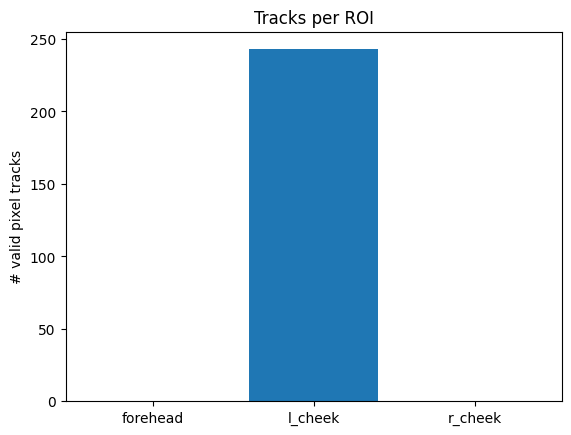

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [18]:
import numpy as np, matplotlib.pyplot as plt
db = np.load("/Users/henryschnieders/Documents/Research/My_Data/mornin_6_16_trajectories.npz", allow_pickle=True)["tracks"]

counts = [sum(tr['region']==r for tr in db) for r in range(3)]
plt.bar(["forehead","l_cheek","r_cheek"], counts)
plt.ylabel("# valid pixel tracks"); plt.title("Tracks per ROI"); plt.show()


for traj in db:
    print(traj['region'])
    if traj['region'] == 'l_cheek':  # forehead
        print(traj['rgb'])

In [19]:
# ------------------------------------------------------------------
#  extra block – CHROM pulse estimate per region
# ------------------------------------------------------------------
from scipy.signal import butter, filtfilt, welch
import numpy as np
import matplotlib.pyplot as plt

#cli inputs
import argparse, os

#merge pdfs
from matplotlib.backends.backend_pdf import PdfPages


def get_params_from_cli_or_prompt():
    """
    • First try to grab --foo and --bar from the command line.
    • If the user didn't provide them, fall back to asking interactively.
    """
    p = argparse.ArgumentParser(description="get data file for pixel trajectories")
    p.add_argument("--data_path", type = str, 
                   default = '/Users/henryschnieders/Documents/Research/My_Data/mornin_6_16_trajectories.npz',
                    help = 'pixel trajectories file path (.npz)' )               # default is None
    args = p.parse_args()

    if args.data_path is None:
        args.data_path = input("Enter the path to the .npy wholeface file:")

    return args.data_path

# # --- organise by region -------------------------------------------------
# region_tracks = [[] for _ in range(n_regions)]        # list of signals

def chrom_bpm(R, G, B, fs, f_lo=0.7, f_hi=4.0):
    """Return (bpm, snr, Xf) where snr is power-ratio around the pulse peak."""
    win = max(1, int(round(1.6 * fs)))
    k   = np.ones(win) / win

    def detrend(v):
        ok = ~np.isnan(v)
        filled = np.where(ok, v, 0.0)
        local  = np.convolve(filled, k, 'same')
        counts = np.convolve(ok.astype(float), k, 'same')
        return np.where(counts > 0, v - local / counts, 0.0)

    r,g,b = map(detrend, (R,G,B))

    Sx = 3*r - 2*g
    Sy = 1.5*r + g - 1.5*b
    alpha = np.nanstd(Sx) / (np.nanstd(Sy) + 1e-8)
    X = Sx - alpha * Sy

    b, a = butter(3, [f_lo/(fs/2), f_hi/(fs/2)], btype='band')
    Xf   = filtfilt(b, a, X)

    f, P = welch(Xf, fs=fs, nperseg=min(512, len(Xf)))
    band = (f >= f_lo) & (f <= f_hi)
    if not np.any(band):
        return np.nan, 0.0, Xf            # no valid band → NaNs

    f_peak = f[band][np.argmax(P[band])]
    bpm    = f_peak * 60.0

    mask_peak = (f >= f_peak-0.2) & (f <= f_peak+0.2)
    snr = P[mask_peak].sum() / (P[band].sum() - P[mask_peak].sum() + 1e-9)

    return bpm, snr, Xf

# ---------- (re)build per-region RGB signals with the φ-mask ----------
# RGB_signals = []   # list of (R,G,B) tuples per region
# for reg in range(n_regions):
#     P = len(region_tracks[reg])
#     if P == 0:
#         RGB_signals.append((np.full_like(region_signals[0], np.nan),)*3)
#         continue

#     # G  : P×T  already exists  (greyscale), but we need R,G,B per track
#     Rm = []; Gm = []; Bm = []
#     MS = np.stack([trk['mask'] for trk in region_tracks[reg]])   # P×(T-2)
#     for trk in region_tracks[reg]:
#         rgb = trk['rgb'].T    # shape 3×T
#         Rm.append(rgb[0]); Gm.append(rgb[1]); Bm.append(rgb[2])
#     Rm, Gm, Bm = map(np.vstack, (Rm, Gm, Bm))   # each: P×T

#     # average with same NaN/φ logic used for greyscale
#     def masked_mean(M):
#         sig = np.zeros(T, np.float32)
#         sig[:]=np.nan
#         sig[0]  = np.nanmean(M[:,0])
#         sig[-1] = np.nanmean(M[:,-1])
#         for t in range(1, T-1):
#             good = MS[:,t-1].astype(bool)
#             sig[t] = np.nanmean(M[good,t]) if good.any() else np.nan
#         return sig[cut:-cut]      # apply same trimming

#     RGB_signals.append(tuple(map(masked_mean, (Rm, Gm, Bm))))

# ---------- rebuild RGB_signals directly ---------------------------

if __name__ == "__main__":

    cut = 25
    fps = 30
    n_regions = 3
    RGB_signals = []
    
    data_path = '/Users/henryschnieders/Documents/Research/My_Data/mornin_6_16_trajectories.npz' #get_params_from_cli_or_prompt()
    
    trajectories_db = np.load(data_path, allow_pickle=True)['tracks']

    n_frames  = len(trajectories_db[0]['rgb'])            # all tracks full-length
            

    for reg in [1]:
        tracks = [tr for tr in trajectories_db if tr['region']==reg]
        if not tracks:
            RGB_signals.append((np.full(n_frames-2*cut, np.nan),)*3)
            continue

        # stack: P×T×3
        cube = np.stack([tr['rgb'] for tr in tracks])       # P×T×3
        # simple mean across tracks (no φ-mask here)
        R = cube[...,0].mean(axis=0)[cut:-cut]
        G = cube[...,1].mean(axis=0)[cut:-cut]
        B = cube[...,2].mean(axis=0)[cut:-cut]
        RGB_signals.append((R, G, B))

    chrom_bpm_est, chrom_snr_est, chrom_traces = [], [], []

    for R, G, B in RGB_signals:
        bpm, snr, trace = chrom_bpm(R, G, B, fps)
        chrom_bpm_est.append(bpm)
        chrom_snr_est.append(snr)
        chrom_traces.append(trace)

    fig1 = plt.figure(figsize=(12,10))

    fig1.suptitle("CHROM no motion process", fontsize=18, y=0.95)

    for r, (tr, bpm, snr) in enumerate(zip(chrom_traces, chrom_bpm_est, chrom_snr_est)):
        plt.subplot(5,1,r+1)
        plt.plot(tr, lw=0.9, label = f"Region {r+1}  (HR≈{bpm:.1f} BPM,  SNR={snr:.1f})")
        plt.ylabel("CHROM\nsignal")
        plt.grid(True)
        if r == 4:
            plt.xlabel("Frame")
        plt.legend()

    plt.savefig('/Users/henryschnieders/Desktop/chrom_signal_per_region2.png', dpi=300)


    figs = [fig1]

    base = os.path.basename(data_path).split('.')[0].replace('rgb_per_region_','') + '_CHROM_nomotionprocess.pdf'

    pdf_path = f'/Users/henryschnieders/Documents/Research/My_Data/{base}'

    with PdfPages(pdf_path) as pdf:
        for f in figs:
            pdf.savefig(f)
            plt.close(f)
    print(pdf_path)   # so the driver can capture it



/Users/henryschnieders/Documents/Research/My_Data/mornin_6_16_trajectories_CHROM_nomotionprocess.pdf


In [26]:

data_path = '/Users/henryschnieders/Documents/Research/My_Data/pixel_trajectories_atnight2_6_15_wholeface.npz'
 #get_params_from_cli_or_prompt()

trajectories_db = np.load(data_path, allow_pickle=True)


trajectories_db['trajectories']


array([{'x0': 283, 'y0': 225, 'rgb': [(86, 86, 134), (86, 86, 134), (86, 86, 134), (86, 86, 134), (86, 86, 134), (86, 86, 134), (87, 87, 136), (87, 86, 137), (87, 86, 137), (87, 86, 137), (87, 86, 137), (87, 86, 137), (87, 86, 137), (87, 86, 137), (87, 86, 137), (87, 86, 137), (86, 84, 136), (86, 84, 136), (86, 84, 136), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (83, 84, 136), (86, 84, 136), (87, 86, 137), (87, 86, 137), (87, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (83, 84, 136), (83, 84, 136), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 86, 137), (84, 87, 136), (84, 87, 136), (83, 86, 134), (83, 86, 134), (83, 86, 134), (86, 86, 134), (83, 86, 134), (83, 86, 134), (83, 86, 134), (8

In [29]:
# ------------------------------------------------------------------
#  extra block – CHROM pulse estimate per region
# ------------------------------------------------------------------
from scipy.signal import butter, filtfilt, welch
import numpy as np
import matplotlib.pyplot as plt

#cli inputs
import argparse, os

#merge pdfs
from matplotlib.backends.backend_pdf import PdfPages


def get_params_from_cli_or_prompt():
    """
    • First try to grab --foo and --bar from the command line.
    • If the user didn't provide them, fall back to asking interactively.
    """
    p = argparse.ArgumentParser(description="get data file for pixel trajectories")
    p.add_argument("--data_path", type = str, help = 'pixel trajectories file path (.npz)' )               # default is None
    args = p.parse_args()

    if args.data_path is None:
        args.data_path = input("Enter the path to the .npz trajectories file:")

    return args.data_path

# # --- organise by region -------------------------------------------------
# region_tracks = [[] for _ in range(n_regions)]        # list of signals

def chrom_bpm(R, G, B, fs, f_lo=0.7, f_hi=4.0):
    """Return (bpm, snr, Xf) where snr is power-ratio around the pulse peak."""
    win = max(1, int(round(1.6 * fs)))
    k   = np.ones(win) / win

    def detrend(v):
        ok = ~np.isnan(v)
        filled = np.where(ok, v, 0.0)
        local  = np.convolve(filled, k, 'same')
        counts = np.convolve(ok.astype(float), k, 'same')
        return np.where(counts > 0, v - local / counts, 0.0)

    r,g,b = map(detrend, (R,G,B))

    Sx = 3*r - 2*g
    Sy = 1.5*r + g - 1.5*b
    alpha = np.nanstd(Sx) / (np.nanstd(Sy) + 1e-8)
    X = Sx - alpha * Sy

    b, a = butter(3, [f_lo/(fs/2), f_hi/(fs/2)], btype='band')
    Xf   = filtfilt(b, a, X)

    f, P = welch(Xf, fs=fs, nperseg=min(512, len(Xf)))
    band = (f >= f_lo) & (f <= f_hi)
    if not np.any(band):
        return np.nan, 0.0, Xf            # no valid band → NaNs

    f_peak = f[band][np.argmax(P[band])]
    bpm    = f_peak * 60.0

    mask_peak = (f >= f_peak-0.2) & (f <= f_peak+0.2)
    snr = P[mask_peak].sum() / (P[band].sum() - P[mask_peak].sum() + 1e-9)

    return bpm, snr, Xf

# ---------- (re)build per-region RGB signals with the φ-mask ----------
# RGB_signals = []   # list of (R,G,B) tuples per region
# for reg in range(n_regions):
#     P = len(region_tracks[reg])
#     if P == 0:
#         RGB_signals.append((np.full_like(region_signals[0], np.nan),)*3)
#         continue

#     # G  : P×T  already exists  (greyscale), but we need R,G,B per track
#     Rm = []; Gm = []; Bm = []
#     MS = np.stack([trk['mask'] for trk in region_tracks[reg]])   # P×(T-2)
#     for trk in region_tracks[reg]:
#         rgb = trk['rgb'].T    # shape 3×T
#         Rm.append(rgb[0]); Gm.append(rgb[1]); Bm.append(rgb[2])
#     Rm, Gm, Bm = map(np.vstack, (Rm, Gm, Bm))   # each: P×T

#     # average with same NaN/φ logic used for greyscale
#     def masked_mean(M):
#         sig = np.zeros(T, np.float32)
#         sig[:]=np.nan
#         sig[0]  = np.nanmean(M[:,0])
#         sig[-1] = np.nanmean(M[:,-1])
#         for t in range(1, T-1):
#             good = MS[:,t-1].astype(bool)
#             sig[t] = np.nanmean(M[good,t]) if good.any() else np.nan
#         return sig[cut:-cut]      # apply same trimming

#     RGB_signals.append(tuple(map(masked_mean, (Rm, Gm, Bm))))

# ---------- rebuild RGB_signals directly ---------------------------

if __name__ == "__main__":
    cut         = 25          # trim this many frames at each end
    fps         = 30
    snr_thresh  = 2.0         # keep trajectories with SNR ≥ this

    data_path   = '/Users/henryschnieders/Documents/Research/My_Data/' \
                'pixel_trajectories_atnight2_6_15_wholeface.npz'

    trajectories_db = np.load(data_path, allow_pickle=True)['trajectories'].tolist()
    n_frames        = len(trajectories_db[0]['rgb'])           # all full length

    ######################################################################
    # 1) CHROM → bpm, snr, trace  for every trajectory
    ######################################################################
    per_track = []       # list of dicts with keys bpm, snr, trace, R,G,B
    for tr in trajectories_db:
        rgb     = np.asarray(tr['rgb'], np.float32)            # T×3
        R, G, B = (rgb[:,0][cut:-cut],
                rgb[:,1][cut:-cut],
                rgb[:,2][cut:-cut])

        bpm, snr, trace = chrom_bpm(R, G, B, fps)
        per_track.append(dict(bpm=bpm, snr=snr, trace=trace,
                            R=R, G=G, B=B))

    ######################################################################
    # 2) filter on SNR
    ######################################################################
    good = [t for t in per_track if t['snr'] >= snr_thresh]

    if not good:
        print(f"No trajectory reached SNR ≥ {snr_thresh:.1f}. "
            "Falling back to using every track.")
        good = per_track

    ######################################################################
    # 3) average RGB of surviving tracks, run CHROM once more
    ######################################################################
    R_mean = np.vstack([t['R'] for t in good]).mean(axis=0)
    G_mean = np.vstack([t['G'] for t in good]).mean(axis=0)
    B_mean = np.vstack([t['B'] for t in good]).mean(axis=0)

    bpm_c, snr_c, trace_c = chrom_bpm(R_mean, G_mean, B_mean, fps)

    ######################################################################
    # 4) plotting
    ######################################################################
    fig = plt.figure(figsize=(12,6))
    fig.suptitle(f"Combined CHROM (N={len(good)} good tracks, "
                f"SNR≥{snr_thresh:.1f})", fontsize=16)

    # light grey traces for each good trajectory
    for t in good:
        plt.plot(t['trace'], lw=0.5, color='0.75')

    # highlighted combined trace
    plt.plot(trace_c, lw=1.8, color='tab:blue',
            label=f"Final  HR≈{bpm_c:.1f} BPM,  SNR={snr_c:.2f}")

    plt.xlabel("Frame");  plt.ylabel("CHROM signal")
    plt.grid(True, ls="--", alpha=0.4)
    plt.legend()

    ######################################################################
    # 5) save to PDF (same naming logic as before)
    ######################################################################
    from matplotlib.backends.backend_pdf import PdfPages
    import os

    base = os.path.basename(data_path).split('.')[0] + '_CHROM_SNRfiltered.pdf'
    pdf_path = f'/Users/henryschnieders/Documents/Research/My_Data/{base}'

    with PdfPages(pdf_path) as pdf:
        pdf.savefig(fig)
        plt.close(fig)

    print(pdf_path)   # so the driver can capture it


/Users/henryschnieders/Documents/Research/My_Data/pixel_trajectories_atnight2_6_15_wholeface_CHROM_SNRfiltered.pdf
